<a href="https://colab.research.google.com/github/Lusimba/HandWritingRec_SGAN/blob/master/HandwritingRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
E: Sub-process /usr/sbin/dpkg-preconfigure --apt || true received signal 2.
E: Failure running script /usr/sbin/dpkg-preconfigure --apt || true


In [10]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [12]:
import os
os.getcwd()
os.listdir('drive/My Drive')



['Colab Notebooks',
 'models',
 'Emotion-updated',
 'ProjectsAi',
 'LearningML',
 'CelebGender',
 'AustralianLotto',
 'Recommender',
 'ObjectClassifier',
 'InternshipProject']

In [0]:
#%cd /content/drive/'My Drive'/ObjectClassifier/GenImages
#!rm *
#!ls

In [0]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Activation
from matplotlib import pyplot
from keras import backend

#Custom activation Function

In [0]:
def custom_activation(output):
	logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
	result = logexpsum / (logexpsum + 1.0)
	return result

#Standalone supervised and unsupervised discriminator models

In [0]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
  # image input
	in_image = Input(shape=in_shape)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output layer nodes
	fe = Dense(n_classes)(fe)
	# supervised output
	c_out_layer = Activation('softmax')(fe)
	# define and compile supervised discriminator model
	c_model = Model(in_image, c_out_layer)
	c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
	# unsupervised output
	d_out_layer = Lambda(custom_activation)(fe)
	# define and compile unsupervised discriminator model
	d_model = Model(in_image, d_out_layer)
	d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return d_model, c_model

#define the standalone generator models

In [0]:
def define_generator(latent_dim):
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model(in_lat, out_layer)
	return model

# define the combined generator and discriminate model, for updating the generator


In [0]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect image output from generator as input to discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and outputting a classification
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


#Load the images

In [0]:
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	print(X.shape, trainy.shape)
	return [X, trainy]

#Select a supervised subset of the dataset with balanced classes

In [0]:
def select_supervised_samples(dataset, n_samples=100, n_classes=10):
	X, y = dataset
	X_list, y_list = list(), list()
	n_per_class = int(n_samples / n_classes)
	for i in range(n_classes):
		# get all images for this class
		X_with_class = X[y == i]
		# choose random instances
		ix = randint(0, len(X_with_class), n_per_class)
		# add to list
		[X_list.append(X_with_class[j]) for j in ix]
		[y_list.append(i) for j in ix]
	return asarray(X_list), asarray(y_list)

# select real samples


In [0]:
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

# generate points in latent space as input for the generator


In [0]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	z_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = z_input.reshape(n_samples, latent_dim)
	return z_input

# use the generator to generate n fake examples, with class labels


In [0]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict(z_input)
	# create class labels
	y = zeros((n_samples, 1))
	return images, y

# generate samples and save as a plot and save the model


In [151]:
%cd /content/drive/My Drive/ObjectClassifier/GenImages
!pwd

/content/drive/My Drive/ObjectClassifier/GenImages
/content/drive/My Drive/ObjectClassifier/GenImages


In [0]:
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# evaluate the classifier model
	X, y = dataset
	_, acc = c_model.evaluate(X, y, verbose=0)
	print('Classifier Accuracy: %.3f%%' % (acc * 100))
	# save the generator model
	filename2 = 'g_model_%04d.h5' % (step+1)
	g_model.save(filename2)
	# save the classifier model
	filename3 = 'c_model_%04d.h5' % (step+1)
	c_model.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

# train the generator and discriminator


In [0]:
def train(g_model, d_model, c_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):
	# select supervised dataset
	X_sup, y_sup = select_supervised_samples(dataset)
	print(X_sup.shape, y_sup.shape)
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
	# manually enumerate epochs
	for i in range(n_steps):
		# update supervised discriminator (c)
		[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
		c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
		# update unsupervised discriminator (d)
		[X_real, _], y_real = generate_real_samples(dataset, half_batch)
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update generator (g)
		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		# summarize loss on this batch
		print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model, c_model, latent_dim, dataset)
 

# size of the latent space


In [0]:
latent_dim = 100


# create the discriminator models


In [0]:
d_model, c_model = define_discriminator()


# create the generator


In [0]:
g_model = define_generator(latent_dim)


# create the gan


In [0]:
gan_model = define_gan(g_model, d_model)


# load image data


In [158]:
dataset = load_real_samples()


(60000, 28, 28, 1) (60000,)


#GPU Specs

# train model


In [159]:
train(g_model, d_model, c_model, gan_model, dataset, latent_dim)

(100, 28, 28, 1) (100,)
n_epochs=20, n_batch=100, 1/2=50, b/e=600, steps=12000


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, c[2.290,10], d[0.096,2.398], g[0.095]
>2, c[2.293,10], d[0.092,2.398], g[0.095]
>3, c[2.309,14], d[0.088,2.398], g[0.095]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>4, c[2.267,22], d[0.085,2.399], g[0.095]
>5, c[2.257,18], d[0.082,2.400], g[0.095]
>6, c[2.261,26], d[0.079,2.400], g[0.096]
>7, c[2.243,24], d[0.078,2.395], g[0.097]
>8, c[2.255,18], d[0.078,2.384], g[0.098]
>9, c[2.210,32], d[0.080,2.372], g[0.099]
>10, c[2.186,26], d[0.081,2.367], g[0.100]
>11, c[2.157,32], d[0.076,2.368], g[0.099]
>12, c[2.117,32], d[0.070,2.371], g[0.100]
>13, c[2.201,22], d[0.062,2.368], g[0.101]
>14, c[2.048,34], d[0.050,2.345], g[0.104]
>15, c[2.073,36], d[0.040,2.314], g[0.108]
>16, c[2.043,32], d[0.031,2.289], g[0.111]
>17, c[1.979,42], d[0.024,2.268], g[0.114]
>18, c[1.901,46], d[0.017,2.240], g[0.121]
>19, c[2.042,16], d[0.016,2.172], g[0.134]
>20, c[1.996,26], d[0.021,2.053], g[0.160]
...>595, c[0.027,100], d[0.854,0.599], g[1.102]
>596, c[0.023,100], d[0.537,0.862], g[1.492]
>597, c[0.021,100], d[0.778,0.603], g[1.399]
>598, c[0.028,100], d[1.041,0.921], g[1.264]
>599, c[0.024,100], d[0.776,0.697], g[0.974]
>600, c[0.027,100], d[0.729,0.817], g[1.114]
Cl

In [160]:
!pwd

/content/drive/My Drive/ObjectClassifier/GenImages


In [161]:
# example of loading the classifier model and generating images
from numpy import expand_dims
from keras.models import load_model
from keras.datasets.mnist import load_data
# load the model
model = load_model('c_model_7200.h5')
# load the dataset
(trainX, trainy), (testX, testy) = load_data()
# expand to 3d, e.g. add channels
trainX = expand_dims(trainX, axis=-1)
testX = expand_dims(testX, axis=-1)
# convert from ints to floats
trainX = trainX.astype('float32')
testX = testX.astype('float32')
# scale from [0,255] to [-1,1]
trainX = (trainX - 127.5) / 127.5
testX = (testX - 127.5) / 127.5
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
print('Train Accuracy: %.3f%%' % (train_acc * 100))
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))

Train Accuracy: 94.147%
Test Accuracy: 94.420%


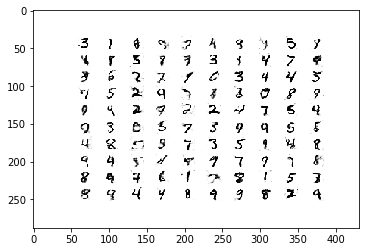

In [172]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread('generated_plot_7200.png'))
plt.show()